# . Introduction


This is a submission for the Lumiata Covid-19 Global Hackathon. The objective of this hackathaon was to develop solutions that address the challenges this pandemic poses to citizens of the world today and for the impact it will have in the future. Our team has constructed a model to predict the rate of spread of this virus based on demographic, population, and travel data of each state in the United States of America. We believe this model provides valuable insight as to how this virus spreads and which states are most vulnerable to COVID-19 or similar virus outbreaks. 

# .  Imports

In [20]:
import pandas as pd #dataframe tools
import numpy as np #mathematic and logarithmic tools
import seaborn as sns #data visualization tool
import matplotlib.pyplot as plt #data visualization tool
from catboost import CatBoostRegressor #gradient-boosted regression package
from sklearn.model_selection import train_test_split # train/test split
from sklearn.preprocessing import StandardScaler #normalization tool
import itertools #looping tools

# .  Loading Data

Our team gathered case data from John Hopkins, financial data from USGOVERNMENTSPENDING.COM, household and age data from the US Census Bureau, population density data from WORLDPOPULATIONREVIEW.COM, and commute data from U.S. Department of Commerce, U.S. Census Bureau, 2013 American Community Survey.

In [21]:
#John Hopkins COVID-19 Case Data
covid_df = pd.read_csv('COVID-19 Cases.csv')

#Financial Data from USGOVERNMENTSPENDING.COM
gdp_df = pd.read_csv('usgs_state_2020 - usgs_state_2020.csv')

#Household Data from US Census Bureau
household_df = pd.read_excel('household dataset.xlsx')

#Commute Data From U.S. Department of Commerce, U.S. Census Bureau, 2013 American Community Survey
commute_df = pd.read_excel('commute to work (1).xlsx')

#Population Data from WOLLDPOPULATIONREVIEW.COM
density_df = pd.read_csv('population density.csv')

# . Preparing Data for Modeling

The first step in preparing our data is identifying what metric we want to predict. We decided to predict average percentage increase in cases per day after an outbreak has begun but before shelter in place orders are implemented. In order to do this, we created an array of pandas dataframes of cases after outbreak for each state with state names as keys, then created a combined dataframe average percentage increase in cases per day from this array. This took many lines of code because we had to find each shelter in place start date online, then manually subset each dataframe in the array to end at each shelter in place start date.

In [22]:
#subsetting covid_df to only include US cases
us_df = covid_df[covid_df['Country_Region']=='US']

#subsetting us_df to only include confirmed cases, sorted by date
us_cases_df = us_df[us_df['Case_Type']=='Confirmed'].sort_values(by=['Date'])

#creating an empty array
state_collection = {}

#looping to fill the array with confirmed case dataframes for each state above our case outbreak threshold of 10
for state in us_cases_df['Province_State'].unique():
    state_collection[state] = us_cases_df[us_cases_df['Province_State']==state].groupby('Date')['Cases'].sum().sort_values()[us_cases_df[us_cases_df['Province_State']==state].groupby('Date')['Cases'].sum()>10]

#subsetting dataframes in array to prior to shelter in place orders
#replacing dataframes with the average percentage change per day after subsetting
state_collection['North Carolina'] = state_collection['North Carolina'].head(19).pct_change().mean()
state_collection['Oklahoma'] = state_collection['Oklahoma'].head(21).pct_change().mean()
state_collection['Wisconsin'] = state_collection['Wisconsin'].head(13).pct_change().mean()
state_collection['Kentucky'] = state_collection['Kentucky'].head(14).pct_change().mean()
state_collection['Missouri'] = state_collection['Missouri'].head(21).pct_change().mean()
state_collection['Montana'] = state_collection['Montana'].head(10).pct_change().mean()
state_collection['Kansas'] = state_collection['Kansas'].head(15).pct_change().mean()
state_collection['Nebraska'] = state_collection['Nebraska'].pct_change().mean()
state_collection['Maine'] = state_collection['Maine'].head(18).pct_change().mean()
state_collection['North Dakota'] = state_collection['North Dakota'].pct_change().mean()
state_collection['Iowa'] = state_collection['Iowa'].head(16).pct_change().mean()
state_collection['Washington'] = state_collection['Washington'].head(23).pct_change().mean()
state_collection['Georgia'] = state_collection['Georgia'].head(24).pct_change().mean()
state_collection['Tennessee'] = state_collection['Tennessee'].head(20).pct_change().mean()
state_collection['Michigan'] = state_collection['Michigan'].head(12).pct_change().mean()
state_collection['Minnesota'] = state_collection['Minnesota'].head(15).pct_change().mean()
state_collection['Utah'] = state_collection['Utah'].head(17).pct_change().mean()
state_collection['Alabama'] = state_collection['Alabama'].head(21).pct_change().mean()
state_collection['South Dakota'] = state_collection['South Dakota'].pct_change().mean()
state_collection['Ohio'] = state_collection['Ohio'].head(11).pct_change().mean()
state_collection['Illinois'] = state_collection['Illinois'].head(12).pct_change().mean()
state_collection['Indiana'] = state_collection['Indiana'].head(14).pct_change().mean()
state_collection['Arkansas'] = state_collection['Arkansas'].iloc[1:].head(16).pct_change().mean()
state_collection['Idaho'] = state_collection['Idaho'].head(7).pct_change().mean()
state_collection['Vermont'] = state_collection['Vermont'].head(10).pct_change().mean()
state_collection['Texas'] = state_collection['Texas'].head(26).pct_change().mean()
state_collection['Virginia'] = state_collection['Virginia'].head(19).pct_change().mean()
state_collection['Mississippi'] = state_collection['Mississippi'].head(19).pct_change().mean()
state_collection['Oregon'] = state_collection['Oregon'].iloc[2:].head(14).pct_change().mean()
state_collection['Pennsylvania'] = state_collection['Pennsylvania'].head(23).pct_change().mean()
state_collection['Puerto Rico'] = state_collection['Puerto Rico'].head(13).pct_change().mean()
state_collection['Florida'] = state_collection['Florida'].head(26).pct_change().mean()
state_collection['California'] = state_collection['California'].head(22).pct_change().mean()
state_collection['Arizona'] = state_collection['Arizona'].iloc[1:].head(17).pct_change().mean()
state_collection['Maryland'] = state_collection['Maryland'].head(19).pct_change().mean()
state_collection['Colorado'] = state_collection['Colorado'].head(17).pct_change().mean()
state_collection['New York'] = state_collection['New York'].head(19).pct_change().mean()
state_collection['Louisiana'] = state_collection['Louisiana'].head(12).pct_change().mean()
state_collection['South Carolina'] = state_collection['South Carolina'].iloc[1:].head(25).pct_change().mean()
#west virginia has too little data before a shelter in place occurs, consider omitting from dataset or iloc[1:]
state_collection['West Virginia'] = state_collection['West Virginia'].head(4).pct_change().mean()
state_collection['Massachusetts'] = state_collection['Massachusetts'].iloc[1:].head(16).pct_change().mean()
state_collection['Delaware'] = state_collection['Delaware'].head(8).pct_change().mean()
state_collection['Nevada'] = state_collection['Nevada'].head(20).pct_change().mean()
state_collection['Rhode Island'] = state_collection['Rhode Island'].head(16).pct_change().mean()
#Alaska is a weird outlier because it has a lot of uninhabitable land, consider omitting from data
state_collection['Alaska'] = state_collection['Alaska'].head(9).pct_change().mean()
state_collection['New Mexico'] = state_collection['New Mexico'].iloc[1:].head(11).pct_change().mean()
state_collection['Connecticut'] = state_collection['Connecticut'].head(11).pct_change().mean()
state_collection['New Jersey'] = state_collection['New Jersey'].head(12).pct_change().mean()
state_collection['Wyoming'] = state_collection['Wyoming'].head(12).pct_change().mean()
state_collection['District of Columbia'] = state_collection['District of Columbia'].head(17).pct_change().mean()
state_collection['Hawaii'] = state_collection['Hawaii'].head(8).pct_change().mean()
state_collection['New Hampshire'] = state_collection['New Hampshire'].head(12).pct_change().mean()
state_collection['Northern Mariana Islands'] = state_collection['Northern Mariana Islands'].head(9).pct_change().mean()
#stay at home order on march 23, before start of subsetted data, consider omitting
state_collection['Virgin Islands'] = state_collection['Virgin Islands'].iloc[2:].head(5).pct_change().mean()
state_collection['Guam'] = state_collection['Guam'].head(9).pct_change().mean()

#converts array keys to attributes in order to build dataframe from array
class AttributeDict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        raise AttributeError(name)

#converting array to series
state_collect_series = pd.Series(state_collection)

#converting series to dataframe
state_collection_df = pd.DataFrame(state_collect_series)

#pushing index values (state names) to column and resetting index to numbers
state_collection_df2 = state_collection_df.reset_index()

#assigning column names
state_collection_df2.columns = ['State','target']

Next, we cleaned the financial data for use in a model.

In [23]:
#dropping unwanted columns from financial data
gdp_df = gdp_df.drop(['Unnamed: 2','State & Local Debt','Unnamed: 4','Unnamed: 6','Unnamed: 8',' a'], axis = 1)

Next, we cleaned the household data for use in a model.

In [24]:
#renaming the 'State name' column to 'State' for merging on that column
household_df = household_df.rename(columns={'State Name': 'State'})

Next, we cleaned the population density data. We removed the population column because it already exists in another dataset.

In [25]:
density_df = density_df.drop(['Population'],
                            axis = 1)

At this point, we proceed to merge our data together into a modeling dataframe.

In [26]:
#merging our target data with financial data
merged_inner = pd.merge(left=gdp_df, right=state_collection_df2, left_on='State', right_on='State')

#merging our merged dataframe with household data
merged_inner = pd.merge(left=merged_inner, right=household_df, left_on='State', right_on='State')

#merging our merged dataframe with density data
merged_inner = pd.merge(left=merged_inner, right=density_df, left_on='State', right_on='State')

#merging our merged dataframe with commute data
merged_inner = pd.merge(left=merged_inner, right=commute_df, left_on='State', right_on='State')

Next we standardized our data before splitting into explanatory and response variable data.

In [27]:
#dropping 'State' column for standardization
merged_inner = merged_inner.drop(['State'], axis=1)

#assigning columns to a variable for re-use later
merged_cols = merged_inner.columns

#instantiating a scaler object
scaler = StandardScaler()

#fitting and transforming our dataframe with the scaler
merged_inner = scaler.fit_transform(merged_inner)

#converting scaled array to a dataframe
merged_inner = pd.DataFrame(merged_inner)

#re-assigning column names with our saved variable
merged_inner.columns = merged_cols

Next, we split our merged data frame into explanatory and response variables for training.

In [28]:
# preparing response variable data
merged_target = merged_inner.loc[:, 'target']

#preparing explanatory variable data
merged_data   = merged_inner.drop(['target'], axis=1)

Next, we split our data into training and testing sets for modeling.

In [29]:
#splitting our testing and training sets with split ratio of .5
X_train, X_test, y_train, y_test = train_test_split(
            merged_data,
            merged_target,
            test_size = 0.3,
            random_state = 222)

# . Modeling

We selected gradient boosted regression as our regression of choice, after testing it against various others including Lasso, Ridge, Linear, and ARD. Gradient Boosted Regression with catboost by far had the best performance.

In [30]:
# INSTANTIATING a model object with chosen hyperparamaters
cat_model = CatBoostRegressor(iterations = 500, depth = 4, learning_rate = .111, eval_metric='R2')

# FITTING the training data
cat_fit = cat_model.fit(X_train, y_train,
                        use_best_model=True,
                        eval_set= (X_test, y_test))


# PREDICTING on new data
cat_pred = cat_model.predict(X_test)

# PREDICTING on training data for boosting
cat_pred1 = cat_model.predict(X_train)

# saving scoring data for future use
cat_train_score = cat_model.score(X_train, y_train).round(4)
cat_test_score  = cat_model.score(X_test, y_test).round(4)

################################################################################
# Final Model Score (score)
################################################################################

#printing train and test score
print('Training Score:', cat_model.score(X_train, y_train).round(4))
print('Testing Score:',  cat_model.score(X_test, y_test).round(4))

0:	learn: 0.0477102	test: 0.0163964	best: 0.0163964 (0)	total: 721us	remaining: 360ms
1:	learn: 0.1135977	test: 0.0729469	best: 0.0729469 (1)	total: 1.17ms	remaining: 291ms
2:	learn: 0.1700750	test: 0.1100273	best: 0.1100273 (2)	total: 1.56ms	remaining: 259ms
3:	learn: 0.2181926	test: 0.1184444	best: 0.1184444 (3)	total: 1.95ms	remaining: 242ms
4:	learn: 0.2587215	test: 0.1428299	best: 0.1428299 (4)	total: 2.42ms	remaining: 240ms
5:	learn: 0.3119253	test: 0.1863812	best: 0.1863812 (5)	total: 2.85ms	remaining: 234ms
6:	learn: 0.3397296	test: 0.2035064	best: 0.2035064 (6)	total: 3.26ms	remaining: 230ms
7:	learn: 0.3769605	test: 0.2260856	best: 0.2260856 (7)	total: 3.68ms	remaining: 227ms
8:	learn: 0.4167538	test: 0.2542070	best: 0.2542070 (8)	total: 4.11ms	remaining: 224ms
9:	learn: 0.4459269	test: 0.2728875	best: 0.2728875 (9)	total: 4.54ms	remaining: 222ms
10:	learn: 0.4808375	test: 0.3022290	best: 0.3022290 (10)	total: 5.02ms	remaining: 223ms
11:	learn: 0.5082450	test: 0.3133824	best:

218:	learn: 0.9999350	test: 0.5994729	best: 0.5994729 (218)	total: 94.5ms	remaining: 121ms
219:	learn: 0.9999381	test: 0.5994910	best: 0.5994910 (219)	total: 94.9ms	remaining: 121ms
220:	learn: 0.9999409	test: 0.5995052	best: 0.5995052 (220)	total: 95.4ms	remaining: 120ms
221:	learn: 0.9999441	test: 0.5994289	best: 0.5995052 (220)	total: 95.8ms	remaining: 120ms
222:	learn: 0.9999460	test: 0.5994628	best: 0.5995052 (220)	total: 96.2ms	remaining: 119ms
223:	learn: 0.9999474	test: 0.5995101	best: 0.5995101 (223)	total: 96.5ms	remaining: 119ms
224:	learn: 0.9999480	test: 0.5995014	best: 0.5995101 (223)	total: 97.1ms	remaining: 119ms
225:	learn: 0.9999510	test: 0.5995297	best: 0.5995297 (225)	total: 97.5ms	remaining: 118ms
226:	learn: 0.9999516	test: 0.5995216	best: 0.5995297 (225)	total: 97.9ms	remaining: 118ms
227:	learn: 0.9999522	test: 0.5995137	best: 0.5995297 (225)	total: 98.3ms	remaining: 117ms
228:	learn: 0.9999549	test: 0.5995417	best: 0.5995417 (228)	total: 98.7ms	remaining: 117ms

316:	learn: 0.9999983	test: 0.6000579	best: 0.6000733 (314)	total: 152ms	remaining: 87.6ms
317:	learn: 0.9999984	test: 0.6000655	best: 0.6000733 (314)	total: 152ms	remaining: 87.1ms
318:	learn: 0.9999985	test: 0.6000838	best: 0.6000838 (318)	total: 153ms	remaining: 86.7ms
319:	learn: 0.9999986	test: 0.6000950	best: 0.6000950 (319)	total: 153ms	remaining: 86.1ms
320:	learn: 0.9999986	test: 0.6000938	best: 0.6000950 (319)	total: 154ms	remaining: 85.6ms
321:	learn: 0.9999986	test: 0.6000926	best: 0.6000950 (319)	total: 154ms	remaining: 85.1ms
322:	learn: 0.9999986	test: 0.6000980	best: 0.6000980 (322)	total: 154ms	remaining: 84.6ms
323:	learn: 0.9999987	test: 0.6000914	best: 0.6000980 (322)	total: 155ms	remaining: 84.1ms
324:	learn: 0.9999987	test: 0.6000852	best: 0.6000980 (322)	total: 155ms	remaining: 83.6ms
325:	learn: 0.9999988	test: 0.6000897	best: 0.6000980 (322)	total: 156ms	remaining: 83ms
326:	learn: 0.9999988	test: 0.6000939	best: 0.6000980 (322)	total: 156ms	remaining: 82.6ms
3

487:	learn: 1.0000000	test: 0.6001408	best: 0.6001790 (354)	total: 225ms	remaining: 5.52ms
488:	learn: 1.0000000	test: 0.6001407	best: 0.6001790 (354)	total: 225ms	remaining: 5.06ms
489:	learn: 1.0000000	test: 0.6001409	best: 0.6001790 (354)	total: 225ms	remaining: 4.6ms
490:	learn: 1.0000000	test: 0.6001406	best: 0.6001790 (354)	total: 226ms	remaining: 4.14ms
491:	learn: 1.0000000	test: 0.6001412	best: 0.6001790 (354)	total: 226ms	remaining: 3.68ms
492:	learn: 1.0000000	test: 0.6001411	best: 0.6001790 (354)	total: 227ms	remaining: 3.22ms
493:	learn: 1.0000000	test: 0.6001410	best: 0.6001790 (354)	total: 227ms	remaining: 2.76ms
494:	learn: 1.0000000	test: 0.6001408	best: 0.6001790 (354)	total: 228ms	remaining: 2.3ms
495:	learn: 1.0000000	test: 0.6001406	best: 0.6001790 (354)	total: 228ms	remaining: 1.84ms
496:	learn: 1.0000000	test: 0.6001404	best: 0.6001790 (354)	total: 229ms	remaining: 1.38ms
497:	learn: 1.0000000	test: 0.6001399	best: 0.6001790 (354)	total: 229ms	remaining: 919us
49

Now that we've created the first iteration of our model, we plot feature importances in order to interpret this model for real world use. It is important that this step occurs before boosting.

<BarContainer object of 16 artists>

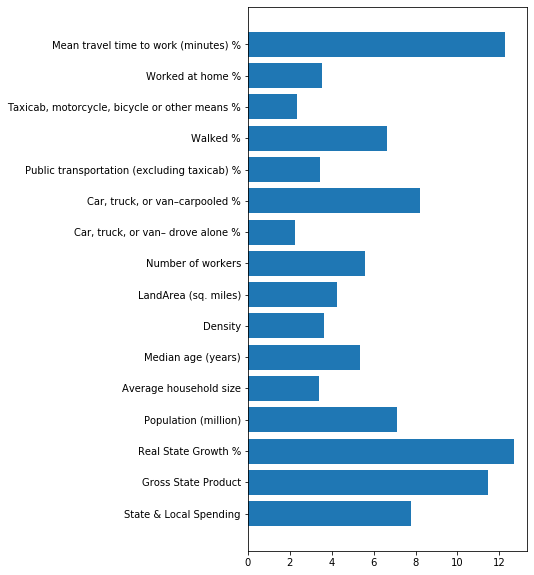

In [31]:
plt.figure(figsize=(5,10))
plt.barh(X_train.columns, cat_model.get_feature_importance(type= "FeatureImportance"))

In [32]:
from sklearn.neighbors import KNeighborsRegressor 
# INSTANTIATING a model with the optimal number of neighbors
knn_stand = KNeighborsRegressor(algorithm = 'auto',
                   n_neighbors = 2)



# FITTING the model based on the training data
knn_stand.fit(X_train, y_train)



# PREDITCING on new data
knn_stand_pred = knn_stand.predict(X_test)

knn_stand_pred1= knn_stand.predict(X_train)


# SCORING the results
print('Training Score:', knn_stand.score(X_train, y_train).round(3))
print('Testing Score:',  knn_stand.score(X_test, y_test).round(3))


# saving scoring data for future use
knn_stand_score_train = knn_stand.score(X_train, y_train).round(3)
knn_stand_score_test  = knn_stand.score(X_test, y_test).round(3)

Training Score: 0.549
Testing Score: 0.319


In preparation for boosting our model, we bind the training and testing set predictions to their respective datasets.

In [33]:
#binding predictions for boosting
X_train['knn predictions'] = knn_stand_pred1
X_test['knn predictions'] = knn_stand_pred

#binding predictions for boosting
X_train['cat predictions'] = cat_pred1
X_test['cat predictions'] = cat_pred


C:\Users\abramson\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\abramson\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\abramson\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set o

Lastly, we boost our model off of predictions from other models, resulting in a 4% increase in variance explained by the model.

In [34]:
# INSTANTIATING a model object with chosen hyperparamaters

cat_model = CatBoostRegressor(iterations = 500, depth = 6, learning_rate = .2004, eval_metric='R2')

# FITTING the training data
cat_fit = cat_model.fit(X_train, y_train,
                        use_best_model=True,
                        eval_set= (X_test, y_test))


# PREDICTING on new data
cat_pred = cat_model.predict(X_test)
cat_pred1 = cat_model.predict(X_train)
# saving scoring data for future use
cat_train_score = cat_model.score(X_train, y_train).round(4)
cat_test_score  = cat_model.score(X_test, y_test).round(4)

################################################################################
# Final Model Score (score)
################################################################################

#printing train and test score
print('Training Score:', cat_model.score(X_train, y_train).round(4))
print('Testing Score:',  cat_model.score(X_test, y_test).round(4))

0:	learn: 0.1431905	test: 0.0666659	best: 0.0666659 (0)	total: 2.71ms	remaining: 1.35s
1:	learn: 0.2835878	test: 0.1515495	best: 0.1515495 (1)	total: 3.32ms	remaining: 828ms
2:	learn: 0.3793151	test: 0.2250740	best: 0.2250740 (2)	total: 4.02ms	remaining: 666ms
3:	learn: 0.4823860	test: 0.2625163	best: 0.2625163 (3)	total: 4.6ms	remaining: 570ms
4:	learn: 0.5335946	test: 0.2649976	best: 0.2649976 (4)	total: 5.19ms	remaining: 514ms
5:	learn: 0.5753240	test: 0.3008467	best: 0.3008467 (5)	total: 5.93ms	remaining: 488ms
6:	learn: 0.6208587	test: 0.3291158	best: 0.3291158 (6)	total: 6.51ms	remaining: 459ms
7:	learn: 0.6807720	test: 0.3769727	best: 0.3769727 (7)	total: 7.12ms	remaining: 438ms
8:	learn: 0.7282981	test: 0.4190768	best: 0.4190768 (8)	total: 7.71ms	remaining: 421ms
9:	learn: 0.7657560	test: 0.4291435	best: 0.4291435 (9)	total: 8.35ms	remaining: 409ms
10:	learn: 0.8068119	test: 0.4701563	best: 0.4701563 (10)	total: 8.92ms	remaining: 397ms
11:	learn: 0.8342894	test: 0.4992693	best:

215:	learn: 1.0000000	test: 0.6479906	best: 0.6481410 (113)	total: 139ms	remaining: 182ms
216:	learn: 1.0000000	test: 0.6479905	best: 0.6481410 (113)	total: 139ms	remaining: 181ms
217:	learn: 1.0000000	test: 0.6479906	best: 0.6481410 (113)	total: 140ms	remaining: 181ms
218:	learn: 1.0000000	test: 0.6479907	best: 0.6481410 (113)	total: 140ms	remaining: 180ms
219:	learn: 1.0000000	test: 0.6479908	best: 0.6481410 (113)	total: 141ms	remaining: 180ms
220:	learn: 1.0000000	test: 0.6479907	best: 0.6481410 (113)	total: 142ms	remaining: 179ms
221:	learn: 1.0000000	test: 0.6479906	best: 0.6481410 (113)	total: 142ms	remaining: 178ms
222:	learn: 1.0000000	test: 0.6479905	best: 0.6481410 (113)	total: 143ms	remaining: 178ms
223:	learn: 1.0000000	test: 0.6479906	best: 0.6481410 (113)	total: 144ms	remaining: 177ms
224:	learn: 1.0000000	test: 0.6479906	best: 0.6481410 (113)	total: 144ms	remaining: 176ms
225:	learn: 1.0000000	test: 0.6479906	best: 0.6481410 (113)	total: 145ms	remaining: 176ms
226:	learn

437:	learn: 1.0000000	test: 0.6479911	best: 0.6481410 (113)	total: 277ms	remaining: 39.2ms
438:	learn: 1.0000000	test: 0.6479911	best: 0.6481410 (113)	total: 278ms	remaining: 38.6ms
439:	learn: 1.0000000	test: 0.6479911	best: 0.6481410 (113)	total: 278ms	remaining: 38ms
440:	learn: 1.0000000	test: 0.6479911	best: 0.6481410 (113)	total: 279ms	remaining: 37.3ms
441:	learn: 1.0000000	test: 0.6479911	best: 0.6481410 (113)	total: 280ms	remaining: 36.7ms
442:	learn: 1.0000000	test: 0.6479911	best: 0.6481410 (113)	total: 280ms	remaining: 36.1ms
443:	learn: 1.0000000	test: 0.6479911	best: 0.6481410 (113)	total: 281ms	remaining: 35.4ms
444:	learn: 1.0000000	test: 0.6479911	best: 0.6481410 (113)	total: 282ms	remaining: 34.8ms
445:	learn: 1.0000000	test: 0.6479911	best: 0.6481410 (113)	total: 282ms	remaining: 34.2ms
446:	learn: 1.0000000	test: 0.6479911	best: 0.6481410 (113)	total: 283ms	remaining: 33.5ms
447:	learn: 1.0000000	test: 0.6479911	best: 0.6481410 (113)	total: 283ms	remaining: 32.9ms
4

In [35]:
#splitting our testing and training sets with split ratio of .5
X_train, X_test, y_train, y_test = train_test_split(
            merged_data,
            merged_target,
            test_size = 0.3,
            random_state = 222)
X_train['cat predictions1'] = cat_pred1
X_test['cat predictions1'] = cat_pred
# INSTANTIATING a model object with chosen hyperparamaters

cat_model = CatBoostRegressor(iterations = 500, depth = 5, learning_rate = .494, eval_metric='R2')

# FITTING the training data
cat_fit = cat_model.fit(X_train, y_train,
                        use_best_model=True,
                        eval_set= (X_test, y_test))


# PREDICTING on new data
cat_pred = cat_model.predict(X_test)
cat_pred1 = cat_model.predict(X_train)
# saving scoring data for future use
cat_train_score = cat_model.score(X_train, y_train).round(4)
cat_test_score  = cat_model.score(X_test, y_test).round(4)

################################################################################
# Final Model Score (score)
################################################################################

#printing train and test score
print('Training Score:', cat_model.score(X_train, y_train).round(4))
print('Testing Score:',  cat_model.score(X_test, y_test).round(4))

C:\Users\abramson\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\abramson\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0:	learn: 0.3344880	test: 0.1554984	best: 0.1554984 (0)	total: 2.94ms	remaining: 1.47s
1:	learn: 0.5734203	test: 0.3338403	best: 0.3338403 (1)	total: 3.46ms	remaining: 863ms
2:	learn: 0.6867512	test: 0.4262629	best: 0.4262629 (2)	total: 3.96ms	remaining: 656ms
3:	learn: 0.7642474	test: 0.4693155	best: 0.4693155 (3)	total: 4.4ms	remaining: 545ms
4:	learn: 0.8145812	test: 0.4912340	best: 0.4912340 (4)	total: 4.84ms	remaining: 479ms
5:	learn: 0.8675441	test: 0.5326780	best: 0.5326780 (5)	total: 5.29ms	remaining: 436ms
6:	learn: 0.9032694	test: 0.5682688	best: 0.5682688 (6)	total: 5.78ms	remaining: 407ms
7:	learn: 0.9325656	test: 0.5809400	best: 0.5809400 (7)	total: 6.22ms	remaining: 383ms
8:	learn: 0.9519152	test: 0.6170539	best: 0.6170539 (8)	total: 6.75ms	remaining: 368ms
9:	learn: 0.9653058	test: 0.6393705	best: 0.6393705 (9)	total: 7.19ms	remaining: 352ms
10:	learn: 0.9741912	test: 0.6463071	best: 0.6463071 (10)	total: 7.65ms	remaining: 340ms
11:	learn: 0.9813203	test: 0.6529069	best:

241:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 128ms	remaining: 136ms
242:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 128ms	remaining: 136ms
243:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 129ms	remaining: 135ms
244:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 130ms	remaining: 135ms
245:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 130ms	remaining: 134ms
246:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 131ms	remaining: 134ms
247:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 131ms	remaining: 134ms
248:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 132ms	remaining: 133ms
249:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 133ms	remaining: 133ms
250:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 133ms	remaining: 132ms
251:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 134ms	remaining: 132ms
252:	learn: 1.0000000

479:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 260ms	remaining: 10.8ms
480:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 261ms	remaining: 10.3ms
481:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 261ms	remaining: 9.76ms
482:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 262ms	remaining: 9.22ms
483:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 262ms	remaining: 8.67ms
484:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 263ms	remaining: 8.13ms
485:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 263ms	remaining: 7.59ms
486:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 264ms	remaining: 7.04ms
487:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 264ms	remaining: 6.5ms
488:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 265ms	remaining: 5.96ms
489:	learn: 1.0000000	test: 0.6728299	best: 0.6728996 (47)	total: 265ms	remaining: 5.42ms
490:	learn:

<BarContainer object of 17 artists>

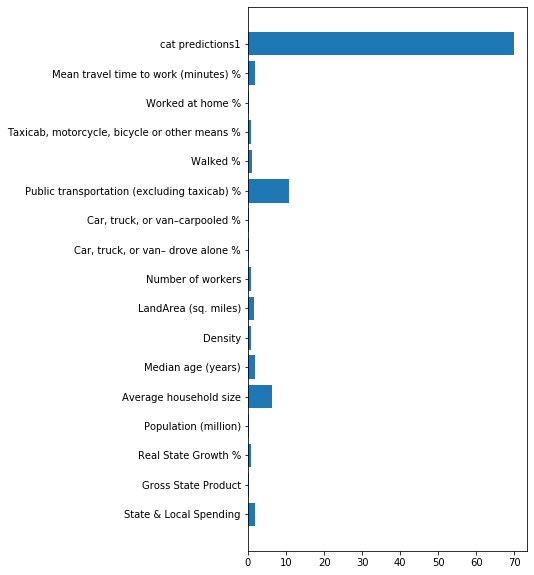

In [36]:
plt.figure(figsize=(5,10))
plt.barh(X_train.columns, cat_model.get_feature_importance(type= "FeatureImportance"))

In [17]:
#splitting our testing and training sets with split ratio of .5
X_train, X_test, y_train, y_test = train_test_split(
            merged_data,
            merged_target,
            test_size = 0.3,
            random_state = 222)
X_train['cat predictions1'] = cat_pred1
X_test['cat predictions1'] = cat_pred
# INSTANTIATING a model object with chosen hyperparamaters

cat_model = CatBoostRegressor(iterations = 500, depth = 5, learning_rate = .42, eval_metric='R2')

# FITTING the training data
cat_fit = cat_model.fit(X_train, y_train,
                        use_best_model=True,
                        eval_set= (X_test, y_test))


# PREDICTING on new data
cat_pred = cat_model.predict(X_test)
cat_pred1 = cat_model.predict(X_train)
# saving scoring data for future use
cat_train_score = cat_model.score(X_train, y_train).round(4)
cat_test_score  = cat_model.score(X_test, y_test).round(4)

################################################################################
# Final Model Score (score)
################################################################################

#printing train and test score
print('Training Score:', cat_model.score(X_train, y_train).round(4))
print('Testing Score:',  cat_model.score(X_test, y_test).round(4))

0:	learn: 0.2930456	test: 0.1388095	best: 0.1388095 (0)	total: 729us	remaining: 364ms
1:	learn: 0.5161217	test: 0.3042411	best: 0.3042411 (1)	total: 1.63ms	remaining: 407ms
2:	learn: 0.6308372	test: 0.4037456	best: 0.4037456 (2)	total: 2.15ms	remaining: 357ms
3:	learn: 0.7103972	test: 0.4386143	best: 0.4386143 (3)	total: 2.65ms	remaining: 329ms
4:	learn: 0.7960229	test: 0.4875126	best: 0.4875126 (4)	total: 3.13ms	remaining: 310ms
5:	learn: 0.8477574	test: 0.5249957	best: 0.5249957 (5)	total: 3.73ms	remaining: 307ms
6:	learn: 0.8823857	test: 0.5587708	best: 0.5587708 (6)	total: 4.42ms	remaining: 311ms
7:	learn: 0.9136177	test: 0.5711757	best: 0.5711757 (7)	total: 4.94ms	remaining: 304ms
8:	learn: 0.9352465	test: 0.6073936	best: 0.6073936 (8)	total: 5.46ms	remaining: 298ms
9:	learn: 0.9514889	test: 0.6275116	best: 0.6275116 (9)	total: 5.92ms	remaining: 290ms
10:	learn: 0.9625946	test: 0.6347861	best: 0.6347861 (10)	total: 6.39ms	remaining: 284ms
11:	learn: 0.9727039	test: 0.6489879	best:

C:\Users\abramson\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\abramson\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


173:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 89.5ms	remaining: 168ms
174:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 90.1ms	remaining: 167ms
175:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 90.5ms	remaining: 167ms
176:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 91ms	remaining: 166ms
177:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 91.4ms	remaining: 165ms
178:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 91.9ms	remaining: 165ms
179:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 92.3ms	remaining: 164ms
180:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 92.8ms	remaining: 164ms
181:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 93.3ms	remaining: 163ms
182:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 93.8ms	remaining: 162ms
183:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 94.2ms	remaining: 162ms
184:	learn: 

431:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 220ms	remaining: 34.6ms
432:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 220ms	remaining: 34.1ms
433:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 221ms	remaining: 33.6ms
434:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 221ms	remaining: 33.1ms
435:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 222ms	remaining: 32.6ms
436:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 222ms	remaining: 32.1ms
437:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 223ms	remaining: 31.5ms
438:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 223ms	remaining: 31ms
439:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 224ms	remaining: 30.5ms
440:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 224ms	remaining: 30ms
441:	learn: 1.0000000	test: 0.6725706	best: 0.6785910 (27)	total: 225ms	remaining: 29.5ms
442:	learn: 1.

<BarContainer object of 17 artists>

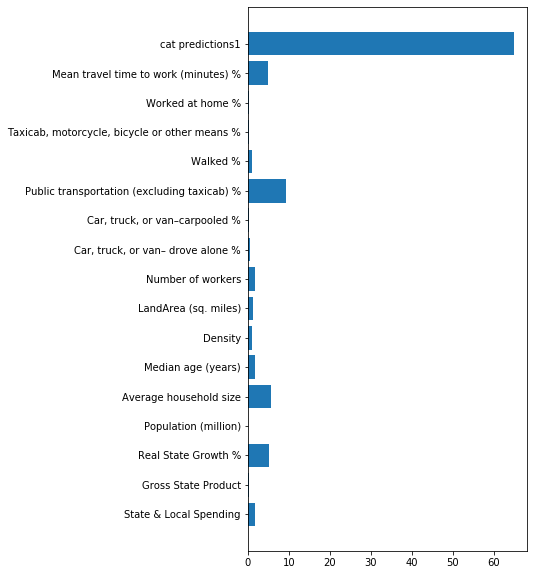

In [18]:
plt.figure(figsize=(5,10))
plt.barh(X_train.columns, cat_model.get_feature_importance(type= "FeatureImportance"))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002743E427648>],
      dtype=object)

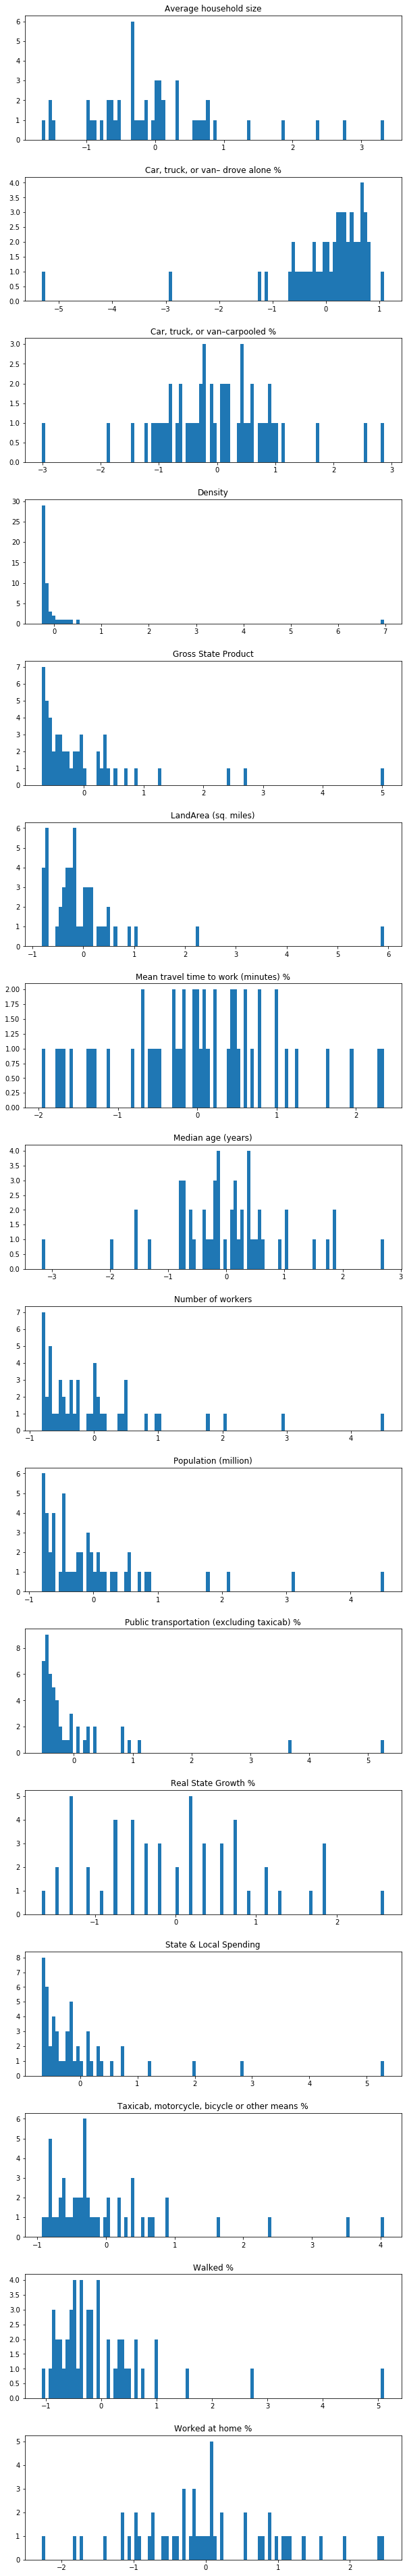